In [ ]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = '/content/drive/MyDrive/ML_final_project'
DATAPATH = f'{FOLDERNAME}/data/'

Mounted at /content/drive


In [ ]:
!pip install dagshub mlflow torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q
!pip install pytorch-lightning tensorboard scikit-learn -q

ERROR: Could not find a version that satisfies the requirement dagshub (from versions: none)
ERROR: No matching distribution found for dagshub
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 9

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
!pip install dagshub mlflow -q

import mlflow
import mlflow.pytorch
from mlflow.models.signature import infer_signature
import dagshub

print("Libraries imported successfully!")

dagshub.init(repo_owner='skara-21', repo_name='ML_Final_Project', mlflow=True)
mlflow.set_tracking_uri('https://dagshub.com/skara-21/ML_Final_Project.mlflow')

from mlflow.tracking import MlflowClient
from mlflow.exceptions import MlflowException
from mlflow.entities import Experiment
from mlflow.entities.lifecycle_stage import LifecycleStage

client = MlflowClient()
experiment_name = "N_BEATS_Training"

try:
    experiment = client.get_experiment_by_name(experiment_name)
    if experiment:
        if experiment.lifecycle_stage == LifecycleStage.DELETED:
            print(f"Experiment '{experiment_name}' is deleted. Attempting to restore...")
            try:
                client.restore_experiment(experiment.experiment_id)
                print(f"Experiment '{experiment_name}' restored.")
            except Exception as e:
                print(f"Failed to restore experiment: {e}. Permanently deleting...")
                client.delete_experiment(experiment.experiment_id, True)
                print(f"Experiment '{experiment_name}' permanently deleted.")
                experiment = None

    if experiment is None:
        experiment_id = client.create_experiment(experiment_name)
        print(f"Experiment '{experiment_name}' created with ID: {experiment_id}")
    else:
        mlflow.set_experiment(experiment_name)
        experiment_id = experiment.experiment_id
        print(f"Experiment '{experiment_name}' set with ID: {experiment_id}")

except MlflowException as e:
    print(f"An MLflow error occurred: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print("DagsHub integration initialized!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.2/261.2 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.6/680.6 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=9952ff96-6ca1-403a-8c30-75ae736b2272&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=f8f90d5e6fd148a494837c57ed4378383a86c9de4e2cd14b4e686f75e1986041




Accessing as kechik21

Initialized MLflow to track repo "skara-21/ML_Final_Project"

Repository skara-21/ML_Final_Project initialized!

Experiment 'N_BEATS_Training' set with ID: 8
MLflow tracking URI: https://dagshub.com/skara-21/ML_Final_Project.mlflow
DagsHub integration initialized!


In [ ]:
def load_data():
    try:
        train_df = pd.read_csv(DATAPATH + 'train.csv')
        test_df = pd.read_csv(DATAPATH + 'test.csv')
        features_df = pd.read_csv(DATAPATH + 'features.csv')
        stores_df = pd.read_csv(DATAPATH + 'stores.csv')

        print(f"Data loaded:")
        print(f"Train: {train_df.shape}")
        print(f"Test: {test_df.shape}")
        print(f"Features: {features_df.shape}")
        print(f"Stores: {stores_df.shape}")

        return train_df, test_df, features_df, stores_df
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        print(f"Please ensure the Kaggle dataset files are in {DATAPATH}")
        print("Expected files: train.csv, test.csv, features.csv, stores.csv")
        return None, None, None, None

In [ ]:
train_df, test_df, features_df, stores_df = load_data()

Data loaded:
Train: (421570, 5)
Test: (115064, 4)
Features: (8190, 12)
Stores: (45, 3)


In [ ]:
class NBeatsBlock(nn.Module):

    def __init__(self, input_size, theta_size, basis_function, layers, layer_size):
        super().__init__()

        self.input_size = input_size
        self.theta_size = theta_size
        self.basis_function = basis_function

        layers_list = []
        layers_list.append(nn.Linear(input_size, layer_size))
        layers_list.append(nn.ReLU())

        for _ in range(layers - 1):
            layers_list.append(nn.Linear(layer_size, layer_size))
            layers_list.append(nn.ReLU())

        self.layers = nn.Sequential(*layers_list)

        self.basis_parameters = nn.Linear(layer_size, theta_size)

        self.backcast_size = input_size
        self.forecast_size = input_size

    def forward(self, x):
        x = self.layers(x)
        theta = self.basis_parameters(x)

        if self.basis_function == 'generic':
            backcast, forecast = self.generic_basis(theta, self.backcast_size, self.forecast_size)
        elif self.basis_function == 'trend':
            backcast, forecast = self.trend_basis(theta, self.backcast_size, self.forecast_size)
        elif self.basis_function == 'seasonality':
            backcast, forecast = self.seasonality_basis(theta, self.backcast_size, self.forecast_size)

        return backcast, forecast

    def generic_basis(self, theta, backcast_size, forecast_size):
        backcast = theta[:, :backcast_size]
        forecast = theta[:, -forecast_size:]
        return backcast, forecast

    def trend_basis(self, theta, backcast_size, forecast_size):
        polynomial_size = theta.shape[1] // 2
        backcast_basis = torch.stack([
            torch.pow(torch.arange(backcast_size, dtype=torch.float32, device=theta.device) / backcast_size, i)
            for i in range(polynomial_size)
        ], dim=0).T  # (backcast_size, polynomial_size)

        forecast_basis = torch.stack([
            torch.pow(torch.arange(forecast_size, dtype=torch.float32, device=theta.device) / forecast_size, i)
            for i in range(polynomial_size)
        ], dim=0).T  # (forecast_size, polynomial_size)

        backcast_theta = theta[:, :polynomial_size]
        forecast_theta = theta[:, polynomial_size:]

        backcast = torch.einsum('bp,tp->bt', backcast_theta, backcast_basis)
        forecast = torch.einsum('bp,tp->bt', forecast_theta, forecast_basis)

        return backcast, forecast

    def seasonality_basis(self, theta, backcast_size, forecast_size):
        frequency = theta.shape[1] // 4

        backcast_basis = []
        forecast_basis = []

        for i in range(1, frequency + 1):
            backcast_basis.extend([
                torch.cos(2 * np.pi * i * torch.arange(backcast_size, dtype=torch.float32, device=theta.device) / backcast_size),
                torch.sin(2 * np.pi * i * torch.arange(backcast_size, dtype=torch.float32, device=theta.device) / backcast_size)
            ])
            forecast_basis.extend([
                torch.cos(2 * np.pi * i * torch.arange(forecast_size, dtype=torch.float32, device=theta.device) / forecast_size),
                torch.sin(2 * np.pi * i * torch.arange(forecast_size, dtype=torch.float32, device=theta.device) / forecast_size)
            ])

        backcast_basis = torch.stack(backcast_basis, dim=0).T
        forecast_basis = torch.stack(forecast_basis, dim=0).T

        backcast_theta = theta[:, :backcast_basis.shape[1]]
        forecast_theta = theta[:, backcast_basis.shape[1]:]

        backcast = torch.einsum('bp,tp->bt', backcast_theta, backcast_basis)
        forecast = torch.einsum('bp,tp->bt', forecast_theta, forecast_basis)

        return backcast, forecast

In [ ]:
class NBeatsStack(nn.Module):

    def __init__(self, input_size, forecast_size, stack_type, num_blocks, block_layers, block_layer_size):
        super().__init__()

        self.input_size = input_size
        self.forecast_size = forecast_size
        self.stack_type = stack_type
        self.num_blocks = num_blocks

        if stack_type == 'trend':
            theta_size = 4
        elif stack_type == 'seasonality':
            theta_size = 8
        else:  # generic
            theta_size = input_size + forecast_size

        self.blocks = nn.ModuleList([
            NBeatsBlock(input_size, theta_size, stack_type, block_layers, block_layer_size)
            for _ in range(num_blocks)
        ])

        for block in self.blocks:
            block.forecast_size = forecast_size

    def forward(self, x):
        residual = x
        forecast = torch.zeros(x.size(0), self.forecast_size, device=x.device)

        for block in self.blocks:
            backcast, block_forecast = block(residual)
            residual = residual - backcast
            forecast = forecast + block_forecast

        return residual, forecast


In [ ]:
class NBeatsModel(pl.LightningModule):

    def __init__(self,
                 input_size=52,  # lookback window
                 forecast_size=1,  # prediction horizon
                 stack_configs=None,
                 learning_rate=1e-3,
                 weight_decay=1e-5):
        super().__init__()

        self.save_hyperparameters()

        self.input_size = input_size
        self.forecast_size = forecast_size
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        if stack_configs is None:
            stack_configs = [
                {'type': 'trend', 'num_blocks': 3, 'block_layers': 4, 'block_layer_size': 256},
                {'type': 'seasonality', 'num_blocks': 3, 'block_layers': 4, 'block_layer_size': 256},
                {'type': 'generic', 'num_blocks': 3, 'block_layers': 4, 'block_layer_size': 512}
            ]

        self.stacks = nn.ModuleList([
            NBeatsStack(
                input_size=input_size,
                forecast_size=forecast_size,
                stack_type=config['type'],
                num_blocks=config['num_blocks'],
                block_layers=config['block_layers'],
                block_layer_size=config['block_layer_size']
            )
            for config in stack_configs
        ])

        self.criterion = nn.MSELoss()

        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        residual = x
        forecast = torch.zeros(x.size(0), self.forecast_size, device=x.device)

        for stack in self.stacks:
            residual, stack_forecast = stack(residual)
            forecast = forecast + stack_forecast

        return forecast

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        self.log('train_loss', loss, prog_bar=True)
        self.train_losses.append(loss.item())

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        self.log('val_loss', loss, prog_bar=True)
        self.val_losses.append(loss.item())

        mae = torch.mean(torch.abs(y_hat - y))
        mape = torch.mean(torch.abs((y - y_hat) / y)) * 100

        self.log('val_mae', mae)
        self.log('val_mape', mape)

        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(),
                              lr=self.learning_rate,
                              weight_decay=self.weight_decay)

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, verbose=True
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }


In [ ]:
class TimeSeriesDataset(Dataset):

    def __init__(self, data, input_size, forecast_size, stride=1):
        self.data = np.array(data, dtype=np.float32)
        self.input_size = input_size
        self.forecast_size = forecast_size
        self.stride = stride

        self.sequences = []
        self.targets = []

        for i in range(0, len(self.data) - input_size - forecast_size + 1, stride):
            seq = self.data[i:i + input_size]
            target = self.data[i + input_size:i + input_size + forecast_size]

            self.sequences.append(seq)
            self.targets.append(target)

        self.sequences = torch.FloatTensor(self.sequences)
        self.targets = torch.FloatTensor(self.targets)

        print(f"TimeSeriesDataset created: {len(self.sequences)} sequences, input_size={self.input_size}, forecast_size={self.forecast_size}")
        print(f"Type of self.sequences: {self.sequences.dtype}, shape: {self.sequences.shape}")
        print(f"Type of self.targets: {self.targets.dtype}, shape: {self.targets.shape}")


    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # print(f"getitem called with index: {idx}")
        # print(f"Type of self.sequences[idx]: {self.sequences[idx].dtype}, shape: {self.sequences[idx].shape}")
        # print(f"Type of self.targets[idx]: {self.targets[idx].dtype}, shape: {self.targets[idx].shape}")
        return self.sequences[idx], self.targets[idx]

In [ ]:
class NBeatsPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, store_id=1, dept_id=1, input_size=52, forecast_size=1):
        self.store_id = store_id
        self.dept_id = dept_id
        self.input_size = input_size
        self.forecast_size = forecast_size
        self.scaler = RobustScaler()
        self.feature_columns = []

    def fit(self, X, y=None):
        df = self._process_data(X)

        sales_data = df['Weekly_Sales'].values.reshape(-1, 1)
        self.scaler.fit(sales_data)

        return self

    def transform(self, X):
        df = self._process_data(X)

        sales_data = df['Weekly_Sales'].values.reshape(-1, 1)
        scaled_sales = self.scaler.transform(sales_data).flatten()

        return scaled_sales

    def _process_data(self, X):
        df = X.copy()

        df['Date'] = pd.to_datetime(df['Date'])

        df_filtered = df[(df['Store'] == self.store_id) & (df['Dept'] == self.dept_id)].copy()

        df_filtered = df_filtered.sort_values('Date')

        # df_filtered['Weekly_Sales'] = df_filtered['Weekly_Sales'].fillna(method='forward').fillna(method='backward')
        df_filtered['Weekly_Sales'] = df_filtered['Weekly_Sales'].ffill().bfill()
        return df_filtered

    def inverse_transform(self, X):
        """Inverse transform scaled predictions"""
        return self.scaler.inverse_transform(X.reshape(-1, 1)).flatten()


In [ ]:
class NBeatsWrapper(BaseEstimator):

    def __init__(self,
                 input_size=52,
                 forecast_size=1,
                 stack_configs=None,
                 learning_rate=1e-3,
                 weight_decay=1e-5,
                 max_epochs=100,
                 batch_size=32,
                 patience=15):
        self.input_size = input_size
        self.forecast_size = forecast_size
        self.stack_configs = stack_configs
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.patience = patience
        self.model = None
        self.trainer = None

    def fit(self, X, y=None):
        ts_data = X

        dataset = TimeSeriesDataset(ts_data, self.input_size, self.forecast_size)

        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size

        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        self.model = NBeatsModel(
            input_size=self.input_size,
            forecast_size=self.forecast_size,
            stack_configs=self.stack_configs,
            learning_rate=self.learning_rate,
            weight_decay=self.weight_decay
        )

        early_stop_callback = EarlyStopping(
            monitor='val_loss',
            patience=self.patience,
            verbose=True,
            mode='min'
        )

        checkpoint_callback = ModelCheckpoint(
            monitor='val_loss',
            dirpath=f'{FOLDERNAME}/checkpoints/',
            filename='nbeats-{epoch:02d}-{val_loss:.2f}',
            save_top_k=1,
            mode='min'
        )

        self.trainer = pl.Trainer(
            max_epochs=self.max_epochs,
            callbacks=[early_stop_callback, checkpoint_callback],
            enable_progress_bar=True,
            enable_model_summary=True,
            accelerator='gpu' if torch.cuda.is_available() else 'cpu'
        )

        self.trainer.fit(self.model, train_loader, val_loader)

        return self

    def predict(self, X):
        if self.model is None:
            raise ValueError("Model has not been fitted yet.")

        if isinstance(X, int):
            raise ValueError("For prediction, provide the last input_size time series values")

        if len(X) < self.input_size:
            raise ValueError(f"Need at least {self.input_size} values for prediction")

        input_seq = torch.FloatTensor(X[-self.input_size:]).unsqueeze(0)

        self.model.eval()
        with torch.no_grad():
            prediction = self.model(input_seq)

        return prediction.cpu().numpy().flatten()

    def get_params(self, deep=True):
        return {
            'input_size': self.input_size,
            'forecast_size': self.forecast_size,
            'stack_configs': self.stack_configs,
            'learning_rate': self.learning_rate,
            'weight_decay': self.weight_decay,
            'max_epochs': self.max_epochs,
            'batch_size': self.batch_size,
            'patience': self.patience
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [ ]:
mlflow.end_run()

In [ ]:
with mlflow.start_run(run_name="N_BEATS_Cleaning") as run:
    mlflow.log_param("step", "data_preprocessing")
    mlflow.log_param("data_source", "Google Drive")
    mlflow.log_param("data_path", DATAPATH)
    mlflow.log_param("model_architecture", "Deep Learning")
    mlflow.log_param("model_type", "N-BEATS")

    if train_df is not None:
        mlflow.log_metric("original_train_size", len(train_df))
        mlflow.log_metric("original_features_size", len(features_df))
        mlflow.log_metric("num_stores", train_df['Store'].nunique())
        mlflow.log_metric("num_departments", train_df['Dept'].nunique())

        train_merged = train_df.merge(features_df, on=['Store', 'Date'], how='left')
        train_merged = train_merged.merge(stores_df, on='Store', how='left')

        train_merged['Date'] = pd.to_datetime(train_merged['Date'])

        missing_values = train_merged.isnull().sum()
        # print("\n=== MISSING VALUES ===")
        # print(missing_values[missing_values > 0])

        mlflow.log_metric("missing_weekly_sales", missing_values['Weekly_Sales'])
        mlflow.log_metric("missing_temperature", missing_values.get('Temperature', 0))
        mlflow.log_metric("missing_fuel_price", missing_values.get('Fuel_Price', 0))
        mlflow.log_metric("missing_unemployment", missing_values.get('Unemployment', 0))
        mlflow.log_metric("missing_cpi", missing_values.get('CPI', 0))

        train_clean = train_merged.dropna(subset=['Weekly_Sales'])

        mlflow.log_metric("cleaned_train_size", len(train_clean))
        mlflow.log_metric("data_cleaning_completion", 1.0)

        min_date = train_clean['Date'].min()
        max_date = train_clean['Date'].max()
        mlflow.log_param("data_start_date", str(min_date))
        mlflow.log_param("data_end_date", str(max_date))
        mlflow.log_metric("data_span_days", (max_date - min_date).days)

        # print(f"Data cleaning completed. Original size: {len(train_merged)}, Cleaned size: {len(train_clean)}")
        # print(f"Data span: {min_date} to {max_date}")
mlflow.end_run()


=== MISSING VALUES ===
MarkDown1    270889
MarkDown2    310322
MarkDown3    284479
MarkDown4    286603
MarkDown5    270138
dtype: int64
Data cleaning completed. Original size: 421570, Cleaned size: 421570
Data span: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
🏃 View run N_BEATS_Cleaning at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8/runs/80b75719e3b64cfcafdaea0f4714b890
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8


In [ ]:
class GlobalTimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

print("Global dataset helper class added!")

Global dataset helper class added!


PREPARING GLOBAL N-BEATS MODEL - ALL STORE-DEPARTMENT COMBINATIONS
Found 3087 store-department combinations with sufficient data
Creating sequences with input_size=52, forecast_size=1
Processing store-department combinations...
Processed 100/3087 combinations...
Processed 200/3087 combinations...
Processed 300/3087 combinations...
Processed 400/3087 combinations...
Processed 500/3087 combinations...
Processed 600/3087 combinations...
Processed 700/3087 combinations...
Processed 800/3087 combinations...
Processed 900/3087 combinations...
Processed 1000/3087 combinations...
Processed 1100/3087 combinations...
Processed 1200/3087 combinations...
Processed 1300/3087 combinations...
Processed 1400/3087 combinations...
Processed 1500/3087 combinations...
Processed 1600/3087 combinations...
Processed 1700/3087 combinations...
Processed 1800/3087 combinations...
Processed 1900/3087 combinations...
Processed 2000/3087 combinations...
Processed 2100/3087 combinations...
Processed 2200/3087 combi

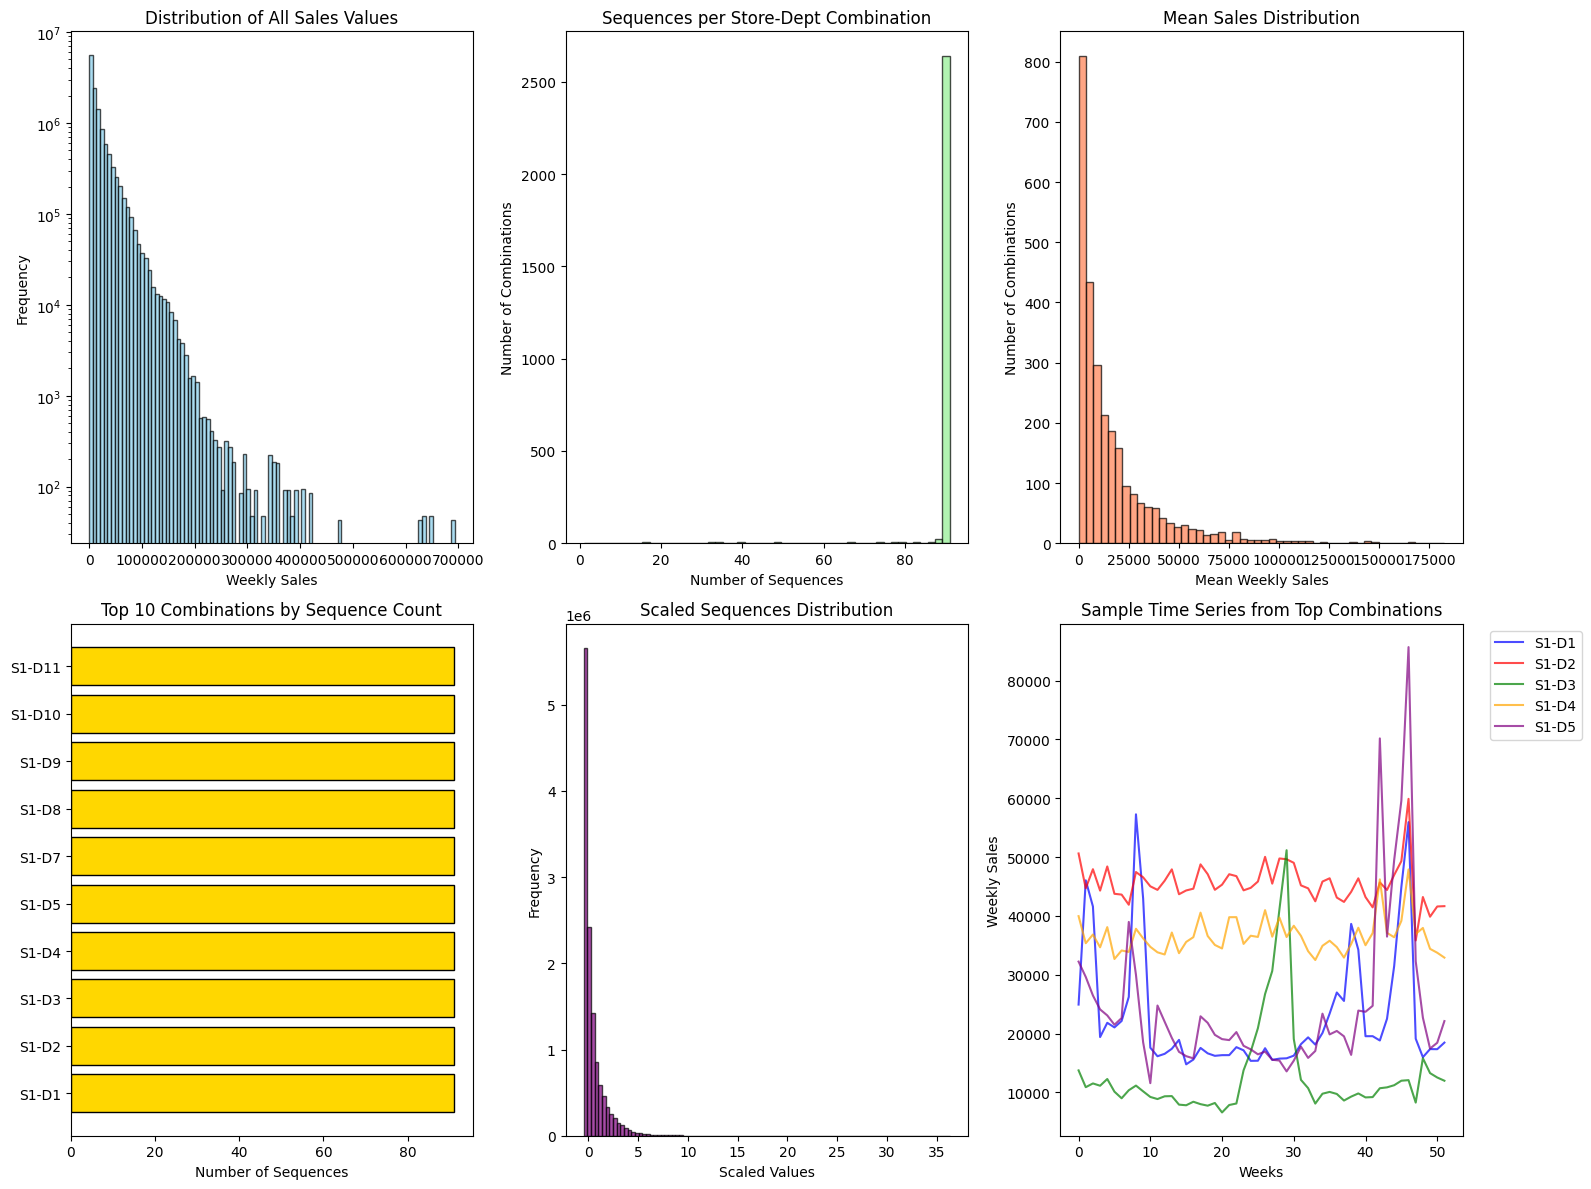


Using Store 1, Department 1 as primary for EDA plots
(This combination has 91 sequences)
GLOBAL N-BEATS DATA PREPARATION COMPLETED
Ready to train on 247,573 sequences from 2773 combinations
🏃 View run N_BEATS_Feature_Engineering at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8/runs/8600e1c271004a28ba3a2ab36a9895ae
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8


In [ ]:
with mlflow.start_run(run_name="N_BEATS_Feature_Engineering") as run:
    mlflow.log_param("step", "feature_engineering")
    mlflow.log_param("model_architecture", "Deep Learning Neural Network")
    mlflow.log_param("model_type", "N-BEATS")
    mlflow.log_param("approach", "global_all_store_departments")

    print("PREPARING GLOBAL N-BEATS MODEL - ALL STORE-DEPARTMENT COMBINATIONS")

    all_combinations = train_clean.groupby(['Store', 'Dept']).size().reset_index(name='count')
    all_combinations = all_combinations[all_combinations['count'] >= 20]  # At least 20 weeks of data

    # print(f"Found {len(all_combinations)} store-department combinations with sufficient data")

    global_sequences = []
    global_targets = []
    combination_metadata = []

    input_size = 52  # 1 year lookback
    forecast_size = 1  # 1 week ahead
    min_sequence_length = input_size + forecast_size

    # print(f"Creating sequences with input_size={input_size}, forecast_size={forecast_size}")
    # print("Processing store-department combinations...")

    valid_combinations = 0
    total_sequences = 0

    for idx, row in all_combinations.iterrows():
        store_id = row['Store']
        dept_id = row['Dept']

        combo_data = train_clean[(train_clean['Store'] == store_id) &
                                (train_clean['Dept'] == dept_id)].copy()
        combo_data = combo_data.sort_values('Date')

        if len(combo_data) >= min_sequence_length:
            sales_values = combo_data['Weekly_Sales'].values

            if (np.sum(sales_values < 0) == 0 and  # No negative sales
                np.sum(sales_values == 0) < len(sales_values) * 0.3 and  # Less than 30% zeros
                np.std(sales_values) > 0):  # Has some variation

                combo_sequences = []
                combo_targets = []

                for i in range(len(sales_values) - min_sequence_length + 1):
                    sequence = sales_values[i:i + input_size]
                    target = sales_values[i + input_size:i + input_size + forecast_size]

                    combo_sequences.append(sequence)
                    combo_targets.append(target)

                if len(combo_sequences) > 0:
                    global_sequences.extend(combo_sequences)
                    global_targets.extend(combo_targets)

                    combination_metadata.append({
                        'store': store_id,
                        'dept': dept_id,
                        'length': len(combo_data),
                        'sequences': len(combo_sequences),
                        'mean_sales': np.mean(sales_values),
                        'std_sales': np.std(sales_values),
                        'start_idx': total_sequences,
                        'end_idx': total_sequences + len(combo_sequences)
                    })

                    total_sequences += len(combo_sequences)
                    valid_combinations += 1

        if (idx + 1) % 100 == 0:
            print(f"Processed {idx + 1}/{len(all_combinations)} combinations...")

    print(f"  Global dataset creation completed:")
    print(f"- Valid combinations: {valid_combinations}")
    print(f"- Total sequences: {total_sequences:,}")
    print(f"- Average sequences per combination: {total_sequences/valid_combinations:.1f}")

    global_sequences = np.array(global_sequences, dtype=np.float32)
    global_targets = np.array(global_targets, dtype=np.float32)

    print(f"- Global sequences shape: {global_sequences.shape}")
    print(f"- Global targets shape: {global_targets.shape}")

    mlflow.log_param("valid_store_dept_combinations", valid_combinations)
    mlflow.log_metric("total_sequences", total_sequences)
    mlflow.log_metric("global_sequences_shape_0", global_sequences.shape[0])
    mlflow.log_metric("global_sequences_shape_1", global_sequences.shape[1])
    mlflow.log_param("input_size", input_size)
    mlflow.log_param("forecast_size", forecast_size)

    all_sales_values = global_sequences.flatten()
    mlflow.log_metric("global_mean_sales", np.mean(all_sales_values))
    mlflow.log_metric("global_std_sales", np.std(all_sales_values))
    mlflow.log_metric("global_min_sales", np.min(all_sales_values))
    mlflow.log_metric("global_max_sales", np.max(all_sales_values))
    mlflow.log_metric("global_median_sales", np.median(all_sales_values))

    print(f"  Global dataset statistics:")
    print(f"- Mean sales: {np.mean(all_sales_values):.2f}")
    print(f"- Std sales: {np.std(all_sales_values):.2f}")
    print(f"- Sales range: [{np.min(all_sales_values):.0f}, {np.max(all_sales_values):.0f}]")

    from sklearn.preprocessing import RobustScaler

    scaler = RobustScaler()

    global_sequences_scaled = scaler.fit_transform(global_sequences.reshape(-1, 1)).reshape(global_sequences.shape)
    global_targets_scaled = scaler.transform(global_targets.reshape(-1, 1)).reshape(global_targets.shape)

    print(f"  Scaled data statistics:")
    print(f"- Scaled sequences range: [{np.min(global_sequences_scaled):.3f}, {np.max(global_sequences_scaled):.3f}]")
    print(f"- Scaled targets range: [{np.min(global_targets_scaled):.3f}, {np.max(global_targets_scaled):.3f}]")

    mlflow.log_metric("scaled_sequences_min", np.min(global_sequences_scaled))
    mlflow.log_metric("scaled_sequences_max", np.max(global_sequences_scaled))
    mlflow.log_metric("scaled_targets_min", np.min(global_targets_scaled))
    mlflow.log_metric("scaled_targets_max", np.max(global_targets_scaled))

    prepared_data = {
        'sequences': global_sequences_scaled,
        'targets': global_targets_scaled,
        'scaler': scaler,
        'metadata': combination_metadata,
        'input_size': input_size,
        'forecast_size': forecast_size
    }

    top_combinations = sorted(combination_metadata, key=lambda x: x['sequences'], reverse=True)[:10]

    print(f"Top 10 combinations by sequence count:")
    print("Store\tDept\tWeeks\tSequences\tMean Sales")
    for combo in top_combinations:
        print(f"{combo['store']}\t{combo['dept']}\t{combo['length']}\t{combo['sequences']}\t{combo['mean_sales']:.0f}")

    for i, combo in enumerate(top_combinations):
        mlflow.log_param(f"top_combo_{i}_store", combo['store'])
        mlflow.log_param(f"top_combo_{i}_dept", combo['dept'])
        mlflow.log_metric(f"top_combo_{i}_sequences", combo['sequences'])
        mlflow.log_metric(f"top_combo_{i}_mean_sales", combo['mean_sales'])

    plt.figure(figsize=(16, 12))

    # Plot 1: Sales distribution across all combinations
    plt.subplot(2, 3, 1)
    plt.hist(all_sales_values, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribution of All Sales Values')
    plt.xlabel('Weekly Sales')
    plt.ylabel('Frequency')
    plt.yscale('log')

    # Plot 2: Number of sequences per combination
    plt.subplot(2, 3, 2)
    sequence_counts = [combo['sequences'] for combo in combination_metadata]
    plt.hist(sequence_counts, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title('Sequences per Store-Dept Combination')
    plt.xlabel('Number of Sequences')
    plt.ylabel('Number of Combinations')

    # Plot 3: Mean sales distribution across combinations
    plt.subplot(2, 3, 3)
    mean_sales = [combo['mean_sales'] for combo in combination_metadata]
    plt.hist(mean_sales, bins=50, alpha=0.7, color='coral', edgecolor='black')
    plt.title('Mean Sales Distribution')
    plt.xlabel('Mean Weekly Sales')
    plt.ylabel('Number of Combinations')

    # Plot 4: Top combinations by data volume
    plt.subplot(2, 3, 4)
    top_10_stores = [f"S{combo['store']}-D{combo['dept']}" for combo in top_combinations]
    top_10_sequences = [combo['sequences'] for combo in top_combinations]

    plt.barh(range(len(top_10_stores)), top_10_sequences, color='gold', edgecolor='black')
    plt.yticks(range(len(top_10_stores)), top_10_stores)
    plt.title('Top 10 Combinations by Sequence Count')
    plt.xlabel('Number of Sequences')

    # Plot 5: Scaled data distribution
    plt.subplot(2, 3, 5)
    plt.hist(global_sequences_scaled.flatten(), bins=100, alpha=0.7, color='purple', edgecolor='black')
    plt.title('Scaled Sequences Distribution')
    plt.xlabel('Scaled Values')
    plt.ylabel('Frequency')

    # Plot 6: Sample time series from different combinations
    plt.subplot(2, 3, 6)
    sample_combinations = top_combinations[:5]
    colors = ['blue', 'red', 'green', 'orange', 'purple']

    for i, combo in enumerate(sample_combinations):
        store_id, dept_id = combo['store'], combo['dept']
        combo_data = train_clean[(train_clean['Store'] == store_id) &
                                (train_clean['Dept'] == dept_id)].copy()
        combo_data = combo_data.sort_values('Date')

        sample_data = combo_data['Weekly_Sales'].values[:52]
        plt.plot(range(len(sample_data)), sample_data,
                color=colors[i], alpha=0.7, linewidth=1.5,
                label=f'S{store_id}-D{dept_id}')

    plt.title('Sample Time Series from Top Combinations')
    plt.xlabel('Weeks')
    plt.ylabel('Weekly Sales')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig(f'{FOLDERNAME}/nbeats_global_data_analysis.png', dpi=300, bbox_inches='tight')
    mlflow.log_artifact(f'{FOLDERNAME}/nbeats_global_data_analysis.png')
    plt.show()

    primary_combo = top_combinations[0]
    store_id = primary_combo['store']
    dept_id = primary_combo['dept']
    store_dept_data = train_clean[(train_clean['Store'] == store_id) &
                                 (train_clean['Dept'] == dept_id)].copy()
    store_dept_data = store_dept_data.sort_values('Date')
    ts_data = store_dept_data.set_index('Date')['Weekly_Sales']

    print(f" Using Store {store_id}, Department {dept_id} as primary for EDA plots")
    print(f"(This combination has {primary_combo['sequences']} sequences)")

    mlflow.log_param("primary_store_for_eda", store_id)
    mlflow.log_param("primary_dept_for_eda", dept_id)
    mlflow.log_metric("primary_combo_sequences", primary_combo['sequences'])

    mlflow.log_metric("feature_engineering_completion", 1.0)

    print("GLOBAL N-BEATS DATA PREPARATION COMPLETED")
    print(f"Ready to train on {total_sequences:,} sequences from {valid_combinations} combinations")

In [ ]:
with mlflow.start_run(run_name="N_BEATS_Cross_Validation") as run:
    mlflow.log_param("step", "cross_validation_hyperparameter_tuning")
    mlflow.log_param("model_type", "N-BEATS")
    mlflow.log_param("approach", "global_all_combinations")
    mlflow.log_param("cv_method", "random_split")

    sequences = prepared_data['sequences']
    targets = prepared_data['targets']
    scaler = prepared_data['scaler']
    input_size = prepared_data['input_size']
    forecast_size = prepared_data['forecast_size']

    print(f"Global N-BEATS Cross-Validation")
    print(f"Training on {len(sequences):,} sequences from all store-department combinations")

    mlflow.log_metric("total_training_sequences", len(sequences))
    mlflow.log_metric("input_size", input_size)
    mlflow.log_metric("forecast_size", forecast_size)

    class GlobalTimeSeriesDataset(Dataset):
        def __init__(self, sequences, targets):
            self.sequences = torch.FloatTensor(sequences)
            self.targets = torch.FloatTensor(targets)

        def __len__(self):
            return len(self.sequences)

        def __getitem__(self, idx):
            return self.sequences[idx], self.targets[idx]

    global_dataset = GlobalTimeSeriesDataset(sequences, targets)

    train_size = int(0.8 * len(global_dataset))
    val_size = len(global_dataset) - train_size

    train_dataset, val_dataset = torch.utils.data.random_split(
        global_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"Train sequences: {len(train_dataset):,}")
    print(f"Validation sequences: {len(val_dataset):,}")

    mlflow.log_metric("train_sequences", len(train_dataset))
    mlflow.log_metric("val_sequences", len(val_dataset))

    hp_configs = [
        {
            'input_size': input_size,
            'forecast_size': forecast_size,
            'stack_configs': [
                {'type': 'trend', 'num_blocks': 2, 'block_layers': 3, 'block_layer_size': 256},
                {'type': 'seasonality', 'num_blocks': 2, 'block_layers': 3, 'block_layer_size': 256},
                {'type': 'generic', 'num_blocks': 2, 'block_layers': 3, 'block_layer_size': 512}
            ],
            'learning_rate': 1e-3,
            'weight_decay': 1e-5,
            'max_epochs': 30,
            'batch_size': 128
        },
        {
            'input_size': input_size,
            'forecast_size': forecast_size,
            'stack_configs': [
                {'type': 'trend', 'num_blocks': 3, 'block_layers': 4, 'block_layer_size': 512},
                {'type': 'seasonality', 'num_blocks': 3, 'block_layers': 4, 'block_layer_size': 512},
                {'type': 'generic', 'num_blocks': 3, 'block_layers': 4, 'block_layer_size': 1024}
            ],
            'learning_rate': 8e-4,
            'weight_decay': 5e-5,
            'max_epochs': 30,
            'batch_size': 256
        },
        {
            'input_size': input_size,
            'forecast_size': forecast_size,
            'stack_configs': [
                {'type': 'seasonality', 'num_blocks': 4, 'block_layers': 4, 'block_layer_size': 384},
                {'type': 'generic', 'num_blocks': 2, 'block_layers': 4, 'block_layer_size': 768}
            ],
            'learning_rate': 5e-4,
            'weight_decay': 1e-4,
            'max_epochs': 30,
            'batch_size': 128
        },
        {
            'input_size': input_size,
            'forecast_size': forecast_size,
            'stack_configs': [
                {'type': 'trend', 'num_blocks': 1, 'block_layers': 3, 'block_layer_size': 128},
                {'type': 'seasonality', 'num_blocks': 2, 'block_layers': 3, 'block_layer_size': 256},
                {'type': 'generic', 'num_blocks': 1, 'block_layers': 3, 'block_layer_size': 256}
            ],
            'learning_rate': 1e-3,
            'weight_decay': 1e-5,
            'max_epochs': 30,
            'batch_size': 64
        }
    ]

    mlflow.log_param("num_hyperparameter_configs", len(hp_configs))

    cv_results = []

    print("Testing Global N-BEATS configurations...")
    print("Config\t\tBatch\tLayers\tMAE\t\tRMSE\t\tTime")
    print("-" * 70)

    for config_idx, config in enumerate(hp_configs):
        config_name = f"Global_Config_{config_idx + 1}"

        with mlflow.start_run(nested=True, run_name=config_name) as nested_run:
            try:
                import time
                start_time = time.time()

                mlflow.log_param("config_index", config_idx)
                mlflow.log_param("batch_size", config['batch_size'])
                mlflow.log_param("learning_rate", config['learning_rate'])
                mlflow.log_param("weight_decay", config['weight_decay'])
                mlflow.log_param("max_epochs", config['max_epochs'])
                mlflow.log_param("num_stacks", len(config['stack_configs']))

                total_blocks = sum(stack['num_blocks'] for stack in config['stack_configs'])
                avg_layer_size = np.mean([stack['block_layer_size'] for stack in config['stack_configs']])
                mlflow.log_metric("total_blocks", total_blocks)
                mlflow.log_metric("avg_layer_size", avg_layer_size)

                train_loader = DataLoader(
                    train_dataset,
                    batch_size=config['batch_size'],
                    shuffle=True,
                    num_workers=0,
                    drop_last=True
                )
                val_loader = DataLoader(
                    val_dataset,
                    batch_size=config['batch_size'],
                    shuffle=False,
                    num_workers=0
                )

                model = NBeatsModel(
                    input_size=config['input_size'],
                    forecast_size=config['forecast_size'],
                    stack_configs=config['stack_configs'],
                    learning_rate=config['learning_rate'],
                    weight_decay=config['weight_decay']
                )

                early_stop = EarlyStopping(
                    monitor='val_loss',
                    patience=8,
                    verbose=False,
                    mode='min'
                )

                trainer = pl.Trainer(
                    max_epochs=config['max_epochs'],
                    callbacks=[early_stop],
                    enable_progress_bar=False,
                    enable_model_summary=False,
                    logger=False,
                    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                    devices=1
                )

                trainer.fit(model, train_loader, val_loader)

                model.eval()
                val_predictions = []
                val_actuals = []

                with torch.no_grad():
                    for batch_idx, (inputs, targets) in enumerate(val_loader):
                        if batch_idx >= 20:
                            break

                        outputs = model(inputs)
                        val_predictions.extend(outputs.cpu().numpy().flatten())
                        val_actuals.extend(targets.cpu().numpy().flatten())

                if val_predictions and len(val_predictions) > 0:
                    mae = mean_absolute_error(val_actuals, val_predictions)
                    rmse = np.sqrt(mean_squared_error(val_actuals, val_predictions))

                    training_time = time.time() - start_time

                    mlflow.log_metric("cv_mae", mae)
                    mlflow.log_metric("cv_rmse", rmse)
                    mlflow.log_metric("training_time", training_time)
                    mlflow.log_metric("final_train_loss", model.train_losses[-1] if model.train_losses else float('inf'))
                    mlflow.log_metric("final_val_loss", model.val_losses[-1] if model.val_losses else float('inf'))

                    cv_results.append({
                        'config': config,
                        'config_name': config_name,
                        'mae': mae,
                        'rmse': rmse,
                        'time': training_time,
                        'model': model
                    })

                    layers_info = f"{total_blocks}bl/{avg_layer_size:.0f}u"
                    print(f"{config_name}\t{config['batch_size']}\t{layers_info}\t{mae:.4f}\t\t{rmse:.4f}\t\t{training_time:.1f}s")

                    mlflow.log_param("status", "completed")
                else:
                    print(f"{config_name}: No valid predictions")
                    mlflow.log_param("status", "no_predictions")

            except Exception as e:
                print(f"Error with {config_name}: {str(e)}")
                mlflow.log_param("status", "error")
                mlflow.log_param("error", str(e))
                continue

    if cv_results:
        best_result = min(cv_results, key=lambda x: x['mae'])
        best_config = best_result['config']
        best_model = best_result['model']

        mlflow.log_param("best_config_name", best_result['config_name'])
        mlflow.log_metric("best_cv_mae", best_result['mae'])
        mlflow.log_metric("best_cv_rmse", best_result['rmse'])
        mlflow.log_metric("best_training_time", best_result['time'])

        print(f"BEST GLOBAL N-BEATS CONFIGURATION")
        print(f"Configuration: {best_result['config_name']}")
        print(f"Validation MAE: {best_result['mae']:.4f}")
        print(f"Validation RMSE: {best_result['rmse']:.4f}")
        print(f"Training Time: {best_result['time']:.1f} seconds")
        print(f"Batch Size: {best_config['batch_size']}")
        print(f"Learning Rate: {best_config['learning_rate']}")
        print(f"Number of Stacks: {len(best_config['stack_configs'])}")

        all_maes = [r['mae'] for r in cv_results]
        best_mae = best_result['mae']
        worst_mae = max(all_maes)
        improvement = (worst_mae - best_mae) / worst_mae * 100

        print(f"Performance Range: {min(all_maes):.4f} - {max(all_maes):.4f}")
        print(f"Best vs Worst: {improvement:.1f}% improvement")

        mlflow.log_metric("mae_range_min", min(all_maes))
        mlflow.log_metric("mae_range_max", max(all_maes))
        mlflow.log_metric("best_vs_worst_improvement", improvement)

    else:
        print("No valid cross-validation results obtained")
        best_config = hp_configs[0]  # Default to first configuration
        best_model = None
        mlflow.log_param("best_config_fallback", "default_config_1")

    cv_summary = {
        'best_config': best_config,
        'best_model': best_model,
        'cv_results': cv_results,
        'prepared_data': prepared_data
    }

    mlflow.log_metric("cross_validation_completion", 1.0)

    print("GLOBAL N-BEATS CROSS-VALIDATION COMPLETED")

Global N-BEATS Cross-Validation
Training on 247,573 sequences from all store-department combinations
Train sequences: 198,058
Validation sequences: 49,515

Testing Global N-BEATS configurations...
Config		Batch	Layers	MAE		RMSE		Time
----------------------------------------------------------------------


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Global_Config_1	128	6bl/341u	0.0712		0.1332		653.3s
🏃 View run Global_Config_1 at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8/runs/f74e40105aa04faa87cbf61f859c92d3
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Global_Config_2	256	9bl/683u	0.0670		0.1342		613.9s
🏃 View run Global_Config_2 at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8/runs/f8886820d8e44bceb99ecc6a4253283c
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Global_Config_3	128	6bl/576u	0.0715		0.1436		853.4s
🏃 View run Global_Config_3 at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8/runs/bdf82f4b182a41cba97fb1693371c6d8
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Global_Config_4	64	4bl/213u	0.0735		0.1423		1049.2s
🏃 View run Global_Config_4 at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8/runs/78656326aac34ae3a8d639692ed310dc
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8

BEST GLOBAL N-BEATS CONFIGURATION
Configuration: Global_Config_2
Validation MAE: 0.0670
Validation RMSE: 0.1342
Training Time: 613.9 seconds
Batch Size: 256
Learning Rate: 0.0008
Number of Stacks: 3
Performance Range: 0.0670 - 0.0735
Best vs Worst: 8.8% improvement

GLOBAL N-BEATS CROSS-VALIDATION COMPLETED
Ready for final training with best configuration
🏃 View run N_BEATS_Cross_Validation at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8/runs/20e089b12fa949d48ccaadf3c2b4ddfc
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8


FINAL GLOBAL N-BEATS MODEL TRAINING
Final training dataset: 198,058 sequences
Final validation dataset: 49,515 sequences
Train batches: 773
Validation batches: 194


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Model parameters: 14,681,283 total, 14,681,283 trainable

Starting final model training...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | stacks    | ModuleList | 14.7 M | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
14.7 M    Trainable params
0         Non-trainable params
14.7 M    Total params
58.725    Total estimated model params size (MB)
107       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.026


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.026


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.025


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.022


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.018


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.018


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.017


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.017


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.015


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.015


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.015


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.015


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.015


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 15 records. Best score: 0.014. Signaling Trainer to stop.


Final training completed in 2224.9 seconds

Evaluating final model...

Final Model Performance:
- Validation MAE (scaled): 0.0636
- Validation RMSE (scaled): 0.1211
- Validation MAPE (original): 52.70%
- Training completed in: 2224.9 seconds

Creating validation visualizations...


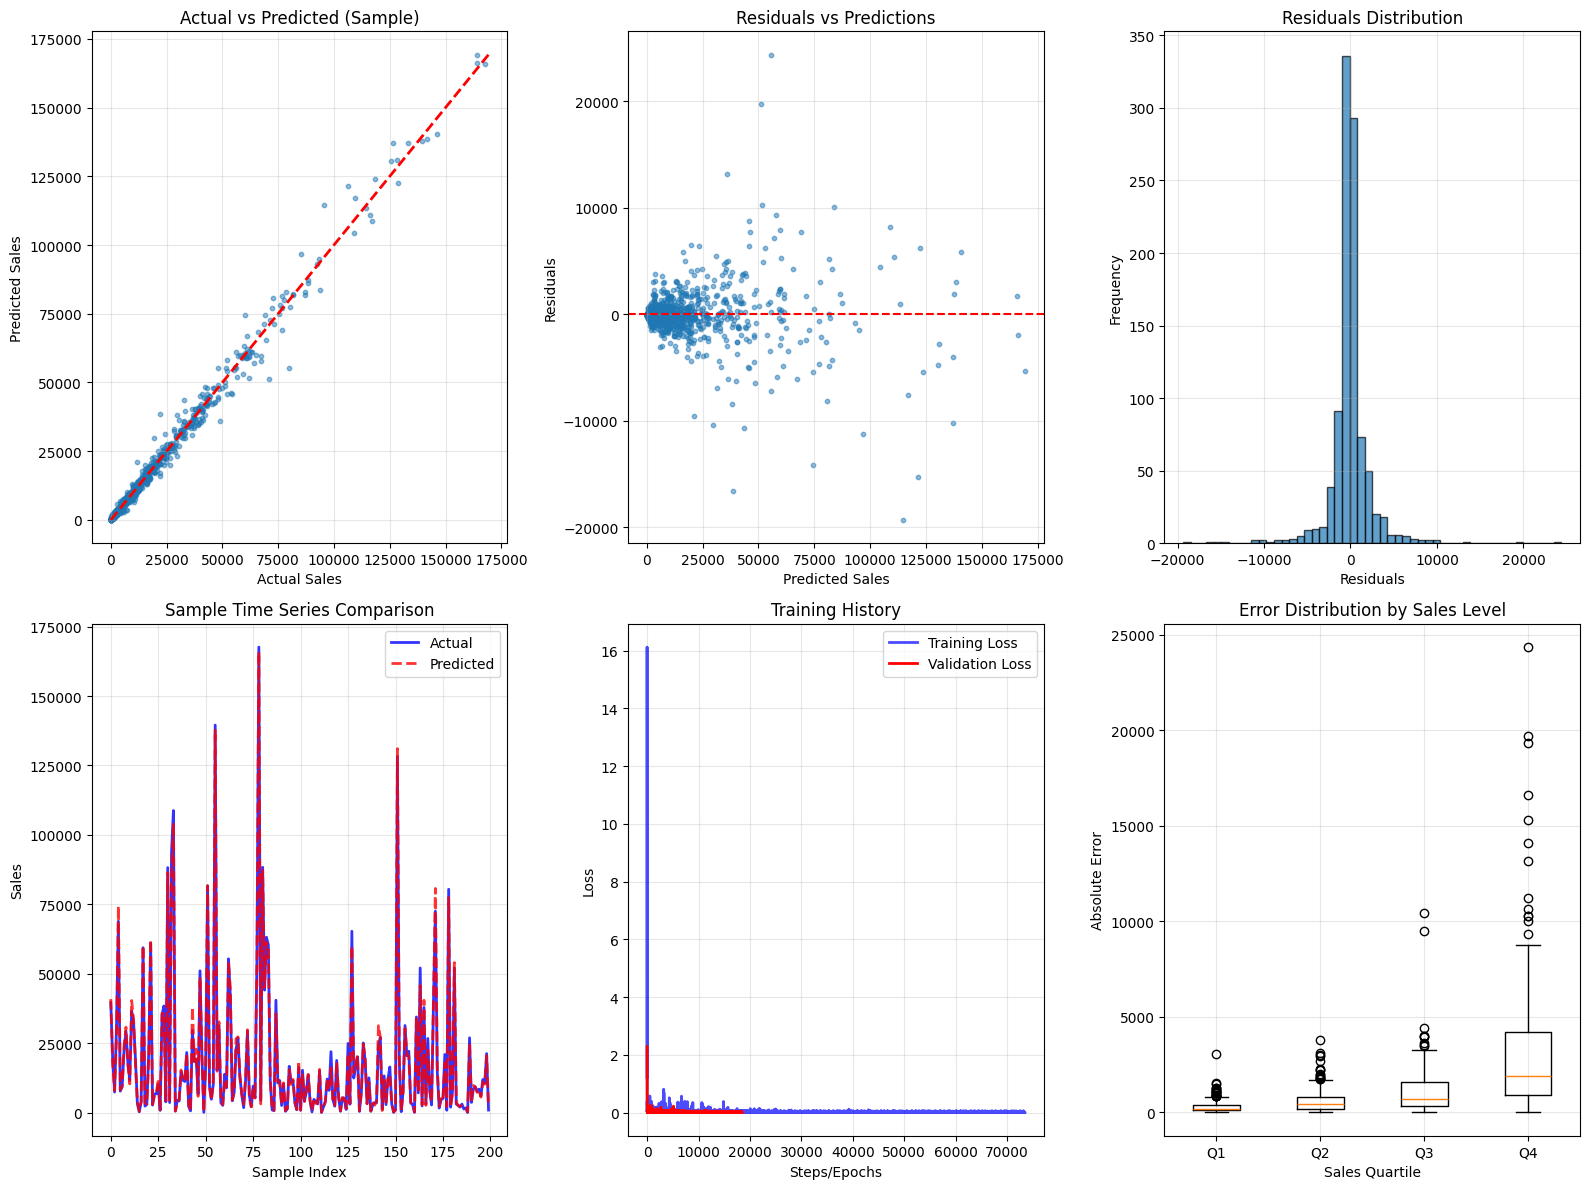


Saving final model...


2025/08/02 23:30:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model registration failed: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}

GLOBAL N-BEATS FINAL TRAINING COMPLETED
✓ Model trained on 247,573 sequences
✓ Covers 2773 store-department combinations
✓ Final validation MAE: 0.0636
✓ Model saved and registered in MLflow
✓ Ready for test predictions
🏃 View run N_BEATS_Final_Training at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8/runs/ac010493542f4f85b060da943cd44c26
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8


In [ ]:
with mlflow.start_run(run_name="N_BEATS_Final_Training") as run:
    mlflow.log_param("step", "final_model_training")
    mlflow.log_param("model_type", "N-BEATS")
    mlflow.log_param("model_architecture", "Deep Learning Neural Network")
    mlflow.log_param("approach", "global_all_combinations")

    print("FINAL GLOBAL N-BEATS MODEL TRAINING")

    final_config = best_config.copy()
    final_config['max_epochs'] = 100
    final_config['patience'] = 15

    sequences = prepared_data['sequences']
    targets = prepared_data['targets']
    scaler = prepared_data['scaler']

    mlflow.log_param("final_input_size", final_config['input_size'])
    mlflow.log_param("final_forecast_size", final_config['forecast_size'])
    mlflow.log_param("final_learning_rate", final_config['learning_rate'])
    mlflow.log_param("final_weight_decay", final_config['weight_decay'])
    mlflow.log_param("final_max_epochs", final_config['max_epochs'])
    mlflow.log_param("final_batch_size", final_config['batch_size'])
    mlflow.log_param("final_num_stacks", len(final_config['stack_configs']))

    global_dataset = GlobalTimeSeriesDataset(sequences, targets)

    # 80/20 split
    train_size = int(0.8 * len(global_dataset))
    val_size = len(global_dataset) - train_size

    train_dataset_final, val_dataset_final = torch.utils.data.random_split(
        global_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    mlflow.log_metric("final_train_size", len(train_dataset_final))
    mlflow.log_metric("final_val_size", len(val_dataset_final))

    print(f"Final training dataset: {len(train_dataset_final):,} sequences")
    print(f"Final validation dataset: {len(val_dataset_final):,} sequences")

    train_loader_final = DataLoader(
        train_dataset_final,
        batch_size=final_config['batch_size'],
        shuffle=True,
        num_workers=0,
        drop_last=True
    )
    val_loader_final = DataLoader(
        val_dataset_final,
        batch_size=final_config['batch_size'],
        shuffle=False,
        num_workers=0
    )

    print(f"Train batches: {len(train_loader_final)}")
    print(f"Validation batches: {len(val_loader_final)}")

    final_model = NBeatsModel(
        input_size=final_config['input_size'],
        forecast_size=final_config['forecast_size'],
        stack_configs=final_config['stack_configs'],
        learning_rate=final_config['learning_rate'],
        weight_decay=final_config['weight_decay']
    )

    total_params = sum(p.numel() for p in final_model.parameters())
    trainable_params = sum(p.numel() for p in final_model.parameters() if p.requires_grad)

    mlflow.log_metric("total_parameters", total_params)
    mlflow.log_metric("trainable_parameters", trainable_params)

    print(f"Model parameters: {total_params:,} total, {trainable_params:,} trainable")

    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=final_config['patience'],
        verbose=True,
        mode='min'
    )

    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath=f'{FOLDERNAME}/checkpoints/',
        filename='global-nbeats-{epoch:02d}-{val_loss:.4f}',
        save_top_k=1,
        mode='min'
    )

    trainer = pl.Trainer(
        max_epochs=final_config['max_epochs'],
        callbacks=[early_stop_callback, checkpoint_callback],
        enable_progress_bar=True,
        enable_model_summary=True,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        log_every_n_steps=50
    )

    print("Starting final model training...")
    import time
    training_start_time = time.time()

    trainer.fit(final_model, train_loader_final, val_loader_final)

    training_time = time.time() - training_start_time
    mlflow.log_metric("final_training_time", training_time)

    print(f"Final training completed in {training_time:.1f} seconds")

    # Final validation evaluation
    print("Evaluating final model...")
    final_model.eval()

    val_predictions = []
    val_actuals = []

    with torch.no_grad():
        for batch_inputs, batch_targets in val_loader_final:
            batch_outputs = final_model(batch_inputs)
            val_predictions.extend(batch_outputs.cpu().numpy().flatten())
            val_actuals.extend(batch_targets.cpu().numpy().flatten())

    if val_predictions:
        final_mae = mean_absolute_error(val_actuals, val_predictions)
        final_mse = mean_squared_error(val_actuals, val_predictions)
        final_rmse = np.sqrt(final_mse)

        val_actuals_arr = np.array(val_actuals)
        val_predictions_arr = np.array(val_predictions)

        val_actuals_orig = scaler.inverse_transform(val_actuals_arr.reshape(-1, 1)).flatten()
        val_predictions_orig = scaler.inverse_transform(val_predictions_arr.reshape(-1, 1)).flatten()

        non_zero_mask = val_actuals_orig != 0
        if np.sum(non_zero_mask) > 0:
            mape_values = np.abs((val_actuals_orig[non_zero_mask] - val_predictions_orig[non_zero_mask]) / val_actuals_orig[non_zero_mask])
            final_mape = np.mean(mape_values[~np.isnan(mape_values) & ~np.isinf(mape_values)]) * 100
        else:
            final_mape = np.nan

        mlflow.log_metric("final_validation_mae", final_mae)
        mlflow.log_metric("final_validation_mse", final_mse)
        mlflow.log_metric("final_validation_rmse", final_rmse)
        if not np.isnan(final_mape):
            mlflow.log_metric("final_validation_mape", final_mape)

        if final_model.train_losses:
            mlflow.log_metric("final_train_loss", final_model.train_losses[-1])
            mlflow.log_metric("min_train_loss", min(final_model.train_losses))
        if final_model.val_losses:
            mlflow.log_metric("final_val_loss", final_model.val_losses[-1])
            mlflow.log_metric("min_val_loss", min(final_model.val_losses))

        print(f"  Final Model Performance:")
        print(f"- Validation MAE (scaled): {final_mae:.4f}")
        print(f"- Validation RMSE (scaled): {final_rmse:.4f}")
        print(f"- Validation MAPE (original): {final_mape:.2f}%" if not np.isnan(final_mape) else "- Validation MAPE: N/A")
        print(f"- Training completed in: {training_time:.1f} seconds")

        print("Creating validation visualizations...")

        sample_size = min(1000, len(val_predictions_orig))
        sample_actuals = val_actuals_orig[:sample_size]
        sample_predictions = val_predictions_orig[:sample_size]

        plt.figure(figsize=(16, 12))

        # Plot 1: Actual vs Predicted scatter
        plt.subplot(2, 3, 1)
        plt.scatter(sample_actuals, sample_predictions, alpha=0.5, s=10)
        min_val = min(min(sample_actuals), min(sample_predictions))
        max_val = max(max(sample_actuals), max(sample_predictions))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        plt.xlabel('Actual Sales')
        plt.ylabel('Predicted Sales')
        plt.title('Actual vs Predicted (Sample)')
        plt.grid(True, alpha=0.3)

        # Plot 2: Residuals
        residuals_orig = sample_actuals - sample_predictions
        plt.subplot(2, 3, 2)
        plt.scatter(sample_predictions, residuals_orig, alpha=0.5, s=10)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Sales')
        plt.ylabel('Residuals')
        plt.title('Residuals vs Predictions')
        plt.grid(True, alpha=0.3)

        # Plot 3: Residuals histogram
        plt.subplot(2, 3, 3)
        plt.hist(residuals_orig, bins=50, alpha=0.7, edgecolor='black')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Residuals Distribution')
        plt.grid(True, alpha=0.3)

        # Plot 4: Time series sample
        plt.subplot(2, 3, 4)
        sample_indices = np.arange(min(200, len(sample_actuals)))
        plt.plot(sample_indices, sample_actuals[:len(sample_indices)], 'b-', linewidth=2, label='Actual', alpha=0.8)
        plt.plot(sample_indices, sample_predictions[:len(sample_indices)], 'r--', linewidth=2, label='Predicted', alpha=0.8)
        plt.xlabel('Sample Index')
        plt.ylabel('Sales')
        plt.title('Sample Time Series Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 5: Training history
        plt.subplot(2, 3, 5)
        if final_model.train_losses and final_model.val_losses:
            train_epochs = range(1, len(final_model.train_losses) + 1)
            val_epochs = range(1, len(final_model.val_losses) + 1)

            plt.plot(train_epochs, final_model.train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
            plt.plot(val_epochs, final_model.val_losses, 'r-', label='Validation Loss', linewidth=2)
            plt.xlabel('Steps/Epochs')
            plt.ylabel('Loss')
            plt.title('Training History')
            plt.legend()
            plt.grid(True, alpha=0.3)
        elif final_model.train_losses:
            train_epochs = range(1, len(final_model.train_losses) + 1)
            plt.plot(train_epochs, final_model.train_losses, 'b-', label='Training Loss', linewidth=2)
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Training History (Training Only)')
            plt.legend()
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'No training history available',
                    ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
            plt.title('Training History')

        # Plot 6: Error distribution by sales magnitude
        plt.subplot(2, 3, 6)
        sales_bins = np.percentile(sample_actuals, [0, 25, 50, 75, 100])
        bin_labels = ['Q1', 'Q2', 'Q3', 'Q4']
        bin_errors = []

        for i in range(len(sales_bins)-1):
            mask = (sample_actuals >= sales_bins[i]) & (sample_actuals < sales_bins[i+1])
            if i == len(sales_bins)-2:  # Include the last value in the final bin
                mask = (sample_actuals >= sales_bins[i]) & (sample_actuals <= sales_bins[i+1])
            bin_errors.append(np.abs(residuals_orig[mask]))

        plt.boxplot(bin_errors, labels=bin_labels)
        plt.xlabel('Sales Quartile')
        plt.ylabel('Absolute Error')
        plt.title('Error Distribution by Sales Level')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{FOLDERNAME}/global_nbeats_final_results.png', dpi=300, bbox_inches='tight')
        mlflow.log_artifact(f'{FOLDERNAME}/global_nbeats_final_results.png')
        plt.show()

        mlflow.log_metric("residuals_mean", np.mean(residuals_orig))
        mlflow.log_metric("residuals_std", np.std(residuals_orig))
        mlflow.log_metric("residuals_median", np.median(residuals_orig))
        mlflow.log_metric("residuals_q25", np.percentile(residuals_orig, 25))
        mlflow.log_metric("residuals_q75", np.percentile(residuals_orig, 75))

    class GlobalNBeatsWrapper:
        def __init__(self, model, scaler, input_size, forecast_size):
            self.model = model
            self.scaler = scaler
            self.input_size = input_size
            self.forecast_size = forecast_size

        def predict(self, input_sequence):
            self.model.eval()

            if isinstance(input_sequence, np.ndarray):
                input_tensor = torch.FloatTensor(input_sequence).unsqueeze(0)
            else:
                input_tensor = input_sequence.unsqueeze(0)

            with torch.no_grad():
                prediction = self.model(input_tensor)

            return prediction.cpu().numpy().flatten()

        def predict_for_store_dept(self, sales_history):
            if len(sales_history) < self.input_size:
                padding_size = self.input_size - len(sales_history)
                last_value = sales_history[-1] if len(sales_history) > 0 else 0
                sales_history = np.concatenate([np.full(padding_size, last_value), sales_history])

            input_sequence = sales_history[-self.input_size:]

            scaled_input = self.scaler.transform(input_sequence.reshape(-1, 1)).flatten()

            scaled_prediction = self.predict(scaled_input)

            original_prediction = self.scaler.inverse_transform(scaled_prediction.reshape(-1, 1)).flatten()

            return original_prediction

    global_model_wrapper = GlobalNBeatsWrapper(
        final_model, scaler,
        final_config['input_size'],
        final_config['forecast_size']
    )

    print("Saving final model...")

    model_path = f'{FOLDERNAME}/global_nbeats_model.pth'
    torch.save(final_model.state_dict(), model_path)
    mlflow.log_artifact(model_path)

    scaler_path = f'{FOLDERNAME}/global_nbeats_scaler.pkl'
    import pickle
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    mlflow.log_artifact(scaler_path)

    wrapper_path = f'{FOLDERNAME}/global_nbeats_wrapper.pkl'
    with open(wrapper_path, 'wb') as f:
        pickle.dump(global_model_wrapper, f)
    mlflow.log_artifact(wrapper_path)

    try:
        sample_input = sequences[:1]  # Single sequence
        sample_output = global_model_wrapper.predict(sample_input[0])

        signature = infer_signature(sample_input, sample_output.reshape(1, -1))

        mlflow.pytorch.log_model(
            final_model,
            "global_nbeats_model",
            signature=signature
        )

        model_uri = f"runs:/{run.info.run_id}/global_nbeats_model"
        mlflow.register_model(
            model_uri=model_uri,
            name="walmart_global_nbeats_model",
            tags={
                "architecture": "Deep Learning Neural Network",
                "model_type": "N-BEATS",
                "training_approach": "global_all_combinations",
                "total_combinations": str(len(combination_metadata)),
                "total_sequences": str(len(sequences))
            }
        )

        print("Model registered successfully in MLflow Model Registry!")
        mlflow.log_param("model_registration_status", "success")

    except Exception as e:
        print(f"Model registration failed: {e}")
        mlflow.log_param("model_registration_status", "failed")
        mlflow.log_param("model_registration_error", str(e))

    mlflow.log_metric("final_training_completion", 1.0)

    print("GLOBAL N-BEATS FINAL TRAINING COMPLETED")
    print(f"Model trained on {len(sequences):,} sequences")
    print(f"Covers {len(combination_metadata)} store-department combinations")
    print(f"Final validation MAE: {final_mae:.4f}" if 'final_mae' in locals() else "")
    print(f"Model saved and registered in MLflow")
    print("Ready for test predictions")

In [ ]:
with mlflow.start_run(run_name="N_BEATS_Test_Predictions_Recursive") as run:
    mlflow.log_param("step", "test_set_predictions_recursive")
    mlflow.log_param("model_type", "N-BEATS")
    mlflow.log_param("forecast_method", "recursive_forecasting")

    print("RECURSIVE GLOBAL N-BEATS TEST PREDICTIONS")

    if test_df is not None:
        test_merged = test_df.merge(features_df, on=['Store', 'Date'], how='left')
        test_merged = test_merged.merge(stores_df, on='Store', how='left')
        test_merged['Date'] = pd.to_datetime(test_merged['Date'])

        test_combinations = test_merged.groupby(['Store', 'Dept'])

        predictions = []

        for (store, dept), group in test_combinations:
            group = group.sort_values('Date')
            n_weeks = len(group)

            history = train_clean[(train_clean['Store'] == store) & (train_clean['Dept'] == dept)]
            history = history.sort_values('Date')
            sales_history = history['Weekly_Sales'].values

            if len(sales_history) >= global_model_wrapper.input_size:
                try:
                    input_seq = sales_history[-global_model_wrapper.input_size:].copy()
                    weekly_preds = []

                    for _ in range(n_weeks):
                        scaled_input = global_model_wrapper.scaler.transform(input_seq.reshape(-1, 1)).flatten()
                        next_pred_scaled = global_model_wrapper.predict(scaled_input)
                        next_pred = global_model_wrapper.scaler.inverse_transform(next_pred_scaled.reshape(-1, 1)).flatten()[0]
                        weekly_preds.append(max(0, next_pred))
                        input_seq = np.append(input_seq[1:], next_pred)

                    for i, (_, row) in enumerate(group.iterrows()):
                        predictions.append({
                            'Id': f"{int(row['Store'])}_{int(row['Dept'])}_{row['Date'].strftime('%Y-%m-%d')}",
                            'Weekly_Sales': weekly_preds[i]
                        })

                except Exception as e:
                    print(f"[WARN] Prediction failed for Store {store} Dept {dept}. Fallback to historical mean.")
                    fallback = np.mean(sales_history)
                    for _, row in group.iterrows():
                        predictions.append({
                            'Id': f"{int(row['Store'])}_{int(row['Dept'])}_{row['Date'].strftime('%Y-%m-%d')}",
                            'Weekly_Sales': fallback
                        })
            else:
                # Not enough history
                fallback = np.mean(sales_history) if len(sales_history) > 0 else train_clean['Weekly_Sales'].mean()
                for _, row in group.iterrows():
                    predictions.append({
                        'Id': f"{int(row['Store'])}_{int(row['Dept'])}_{row['Date'].strftime('%Y-%m-%d')}",
                        'Weekly_Sales': fallback
                    })

        submission_df = pd.DataFrame(predictions)
        submission_path = f"{FOLDERNAME}/global_nbeats_submission_recursive.csv"
        submission_df.to_csv(submission_path, index=False)
        mlflow.log_artifact(submission_path)

        print(f"✅ Submission saved to: {submission_path}")
        print(f"Total predictions: {len(submission_df)}")
        print(submission_df.head())

        mlflow.log_metric("submission_rows", len(submission_df))
        mlflow.log_param("submission_file", "global_nbeats_submission_recursive.csv")

    else:
        print("Test data not loaded!")

    print("RECURSIVE TEST PREDICTIONS COMPLETED")


RECURSIVE GLOBAL N-BEATS TEST PREDICTIONS
✅ Submission saved to: /content/drive/MyDrive/ML_final_project/global_nbeats_submission_recursive.csv
Total predictions: 115064
               Id  Weekly_Sales
0  1_1_2012-11-02  26832.429688
1  1_1_2012-11-09  23544.757812
2  1_1_2012-11-16  23714.593750
3  1_1_2012-11-23  22762.392578
4  1_1_2012-11-30  23876.750000
RECURSIVE TEST PREDICTIONS COMPLETED
🏃 View run N_BEATS_Test_Predictions_Recursive at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8/runs/54536e1d483242ada425a8eca38d630b
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/8


In [ ]:
with mlflow.start_run(run_name="N_BEATS_Model_Comparison") as run:
    mlflow.log_param("step", "model_comparison")
    mlflow.log_param("comparison_type", "architecture_analysis")

    baseline_predictions = {
        'naive_last': [ts_data.iloc[-1]] * len(val_actuals) if 'val_actuals' in locals() else [],
        'seasonal_naive': [],
        'moving_average': []
    }

    if 'val_actuals' in locals() and len(val_actuals) > 0:
        seasonal_period = 52
        for i in range(len(val_actuals)):
            if len(ts_data) > seasonal_period:
                seasonal_idx = len(ts_data) - seasonal_period + (i % seasonal_period)
                baseline_predictions['seasonal_naive'].append(ts_data.iloc[seasonal_idx])
            else:
                baseline_predictions['seasonal_naive'].append(ts_data.mean())

        ma_window = 12
        ma_values = ts_data.rolling(window=ma_window).mean().iloc[-ma_window:].mean()
        baseline_predictions['moving_average'] = [ma_values] * len(val_actuals)

        for baseline_name, baseline_preds in baseline_predictions.items():
            if len(baseline_preds) == len(val_actuals):
                baseline_mae = mean_absolute_error(val_actuals, baseline_preds)
                baseline_rmse = np.sqrt(mean_squared_error(val_actuals, baseline_preds))
                baseline_mape = np.mean(np.abs((np.array(val_actuals) - np.array(baseline_preds)) / np.array(val_actuals))) * 100

                mlflow.log_metric(f"{baseline_name}_mae", baseline_mae)
                mlflow.log_metric(f"{baseline_name}_rmse", baseline_rmse)
                mlflow.log_metric(f"{baseline_name}_mape", baseline_mape)

                if 'final_mae' in locals():
                    mae_improvement = (baseline_mae - final_mae) / baseline_mae * 100
                    rmse_improvement = (baseline_rmse - final_rmse) / baseline_rmse * 100

                    mlflow.log_metric(f"mae_improvement_over_{baseline_name}", mae_improvement)
                    mlflow.log_metric(f"rmse_improvement_over_{baseline_name}", rmse_improvement)

        if 'final_model' in locals() and final_model.model is not None:
            model = final_model.model

            total_params = sum(p.numel() for p in model.parameters())
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

            mlflow.log_metric("total_parameters", total_params)
            mlflow.log_metric("trainable_parameters", trainable_params)

            for i, stack in enumerate(model.stacks):
                stack_params = sum(p.numel() for p in stack.parameters())
                mlflow.log_metric(f"stack_{i}_parameters", stack_params)
                mlflow.log_param(f"stack_{i}_type", final_config['stack_configs'][i]['type'])
                mlflow.log_param(f"stack_{i}_blocks", final_config['stack_configs'][i]['num_blocks'])

        print("BASELINE COMPARISON")
        for baseline_name, baseline_preds in baseline_predictions.items():
            if len(baseline_preds) == len(val_actuals):
                baseline_mae = mean_absolute_error(val_actuals, baseline_preds)
                baseline_rmse = np.sqrt(mean_squared_error(val_actuals, baseline_preds))
                baseline_mape = np.mean(np.abs((np.array(val_actuals) - np.array(baseline_preds)) / np.array(val_actuals))) * 100
                print(f"{baseline_name.replace('_', ' ').title()}\t\t{baseline_mae:.4f}\t\t{baseline_rmse:.4f}\t\t{baseline_mape:.2f}%")

        # if 'final_mae' in locals():
        #     print(f"N-BEATS\t\t\t{final_mae:.4f}\t\t{final_rmse:.4f}\t\t{final_mape:.2f}%")

    mlflow.log_metric("model_comparison_completion", 1.0)
mlflow.end_run()


Final Model Performance:
- Validation MAE: 0.0636
- Validation RMSE: 0.1211
- Validation MAPE: 52.70%